In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import astropy.units as u
import numpy as np
import tracemalloc
import time
import matplotlib.pyplot as plt









In [2]:
mh = '+0.0'
CtoO = '1.0'

filename_db="/Users/sagnickmukherjee/Documents/GitHub/picaso/reference/opacities/ck_cx_cont_opacities.db"
#filename_db="/Users/sagnickmukherjee/Documents/GitHub/Disequilibrium-Picaso/reference/climate_INPUTS/ck_cx_cont_opacities_661.db"
ck_db='/Users/sagnickmukherjee/Documents/software/picaso-dev/reference/opacities/ck_db/m'+mh+'_co'+CtoO+'.data.196'
#ck_db='/Users/sagnickmukherjee/Documents/software/picaso-dev/reference/opacities/ck_db/sonora_2020_feh+000_co_100.data.196'

opacity_ck = jdi.opannection(ck=True, ck_db=ck_db,filename_db=filename_db)#, deq = True, first_deq = True)


In [3]:
# planet prop
semi_major = 0.1 #0.0355 #"NA" # AU
T_eff = 200
grav = 25
r_planet = 1.00 # needed for vulcan photochem runs

### star prop
T_star = 6000.0#"NA"
logg = 4.57
metal = 0.25
r_star = 1.0




nlevel = 91
pressure=np.logspace(np.log10(1e-5),np.log10(1000.0),nlevel)
temp_guess = np.zeros(shape=(nlevel)) 
kz = np.zeros(shape =(nlevel))

for i in range(len(temp_guess)):
    temp_guess[i] = 800+i*20
    

nofczns = 1
nstr = np.array([0,87,89,0,0,0])
rfacv = 0.5
rfaci =1.0
cloudy = False
fsed = 2
if cloudy == True:
    semi_major = str(semi_major)+"_cld_fsed"+str(fsed)



In [4]:
###### run start

cl_run = jdi.inputs(calculation="planet", climate = True)

cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star, radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)#opacity db, pysynphot database, temp, metallicity, logg

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)'))
cl_run.T_eff(Teff=T_eff)





cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure, nstr = nstr, nofczns = nofczns , rfacv = rfacv, rfaci = rfaci, cloudy = cloudy, mh = mh, CtoO = CtoO,species = ['MgSiO3','Mg2SiO4','Fe'], fsed = fsed, T_star = T_star, logg = logg, metal = metal, r_star = r_star, semi_major = semi_major)


t0 = time.time()
pressure , temp, dtdp, nstr_new, flux_plus_final, df, all_profiles = cl_run.run_climate_model(opacity_ck,save_all_profiles=True,diseq_chem = False, self_consistent_kzz =False, kz = kz )
t1 = time.time()
print(t1-t0)


Iteration number  0 , min , max temp  780.9234090673804 3150.783015608122 , flux balance  3883.878840766999
Iteration number  1 , min , max temp  645.7798369022591 4246.528976322329 , flux balance  1122.4910257414865
Iteration number  2 , min , max temp  585.8703682546867 3964.187535290678 , flux balance  276.35277449013245
Iteration number  3 , min , max temp  576.0414293747227 3933.733416883538 , flux balance  41.807913843998676
Iteration number  4 , min , max temp  575.9088242767854 3933.330473370853 , flux balance  1.9365416203603172
Iteration number  5 , min , max temp  575.9119429777578 3933.321815182037 , flux balance  0.009816257110749174
Iteration number  6 , min , max temp  575.9118877379901 3933.3216759800675 , flux balance  3.001601661752819e-06
Converged Solution in iterations  6
Big iteration is  575.9118877379901 0
Iteration number  0 , min , max temp  579.0504361688285 4024.3063339560535 , flux balance  3.9908756269857033
Iteration number  1 , min , max temp  588.839324

In [5]:
t_eq,p_eq,df_eq,all_profiles_eq = np.copy(temp), np.copy(pressure), df,np.copy(all_profiles)

Text(0.5, 1.0, 'T$_{\\rm eff}$= 1000 K, log(g)=5.0')

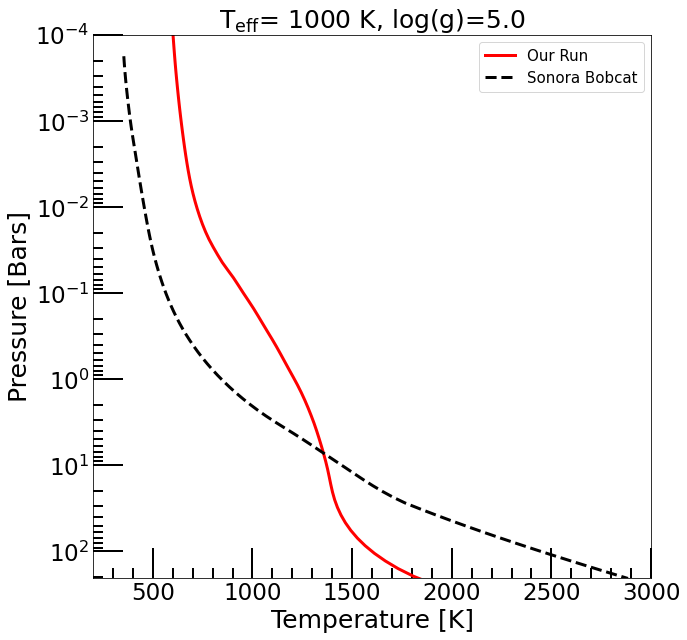

In [6]:
# lets load bobcat model now
pressure_bobcat,temp_bobcat = np.loadtxt("/Users/sagnickmukherjee/Documents/GitHub/Disequilibrium-Picaso/t"+str(1000)+"g1000"+"nc_m0.0.dat",usecols=[1,2],unpack=True, skiprows = 1)

plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(205,1e-4)
plt.xlim(200,3000)

plt.semilogy(temp,pressure,color="r",linewidth=3,label="Our Run")
plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 1000 K, log(g)=5.0",fontsize=25)





In [7]:
co,h2o,nh3,ch4 = np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq)),np.zeros(len(all_profiles_eq))
spec = np.zeros(shape =(int(len(all_profiles_eq)/91),196))
for i in range(int(len(all_profiles_eq)/91)):
#for i in range(5):
    bd = jdi.inputs(calculation='brown')

    bd.phase_angle(0)
    bd.gravity(gravity=25 , gravity_unit=u.Unit('m/s**2'))

    sonora_profile_db = '/Users/sagnickmukherjee/Documents/software/sonora/profile/'
    Teff_dummy = 1000
    bd.sonora(sonora_profile_db, Teff_dummy)
    
    bd.inputs['atmosphere']['profile']['pressure'] =p_eq
    bd.inputs['atmosphere']['profile']['temperature'] = all_profiles_eq[i*91:(i+1)*91]
    bd.premix_atmosphere(opacity_ck,bd.inputs['atmosphere']['profile'])
    
    df_spec = bd.spectrum(opacity_ck,full_output=True)
    spec[i,:] = df_spec['thermal']
    co[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['CO']
    h2o[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['H2O']
    nh3[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['NH3']
    ch4[i*91:(i+1)*91] = bd.inputs['atmosphere']['profile']['CH4']
    #x,y = jdi.mean_regrid(1e4/df_spec['wavenumber'], df_spec['thermal'], R=500)


In [8]:
wh = np.where( (1e4/df_spec['wavenumber'] > 0.0) & (1e4/df_spec['wavenumber'] < 6))
wv = 1e4/df_spec['wavenumber'][wh]


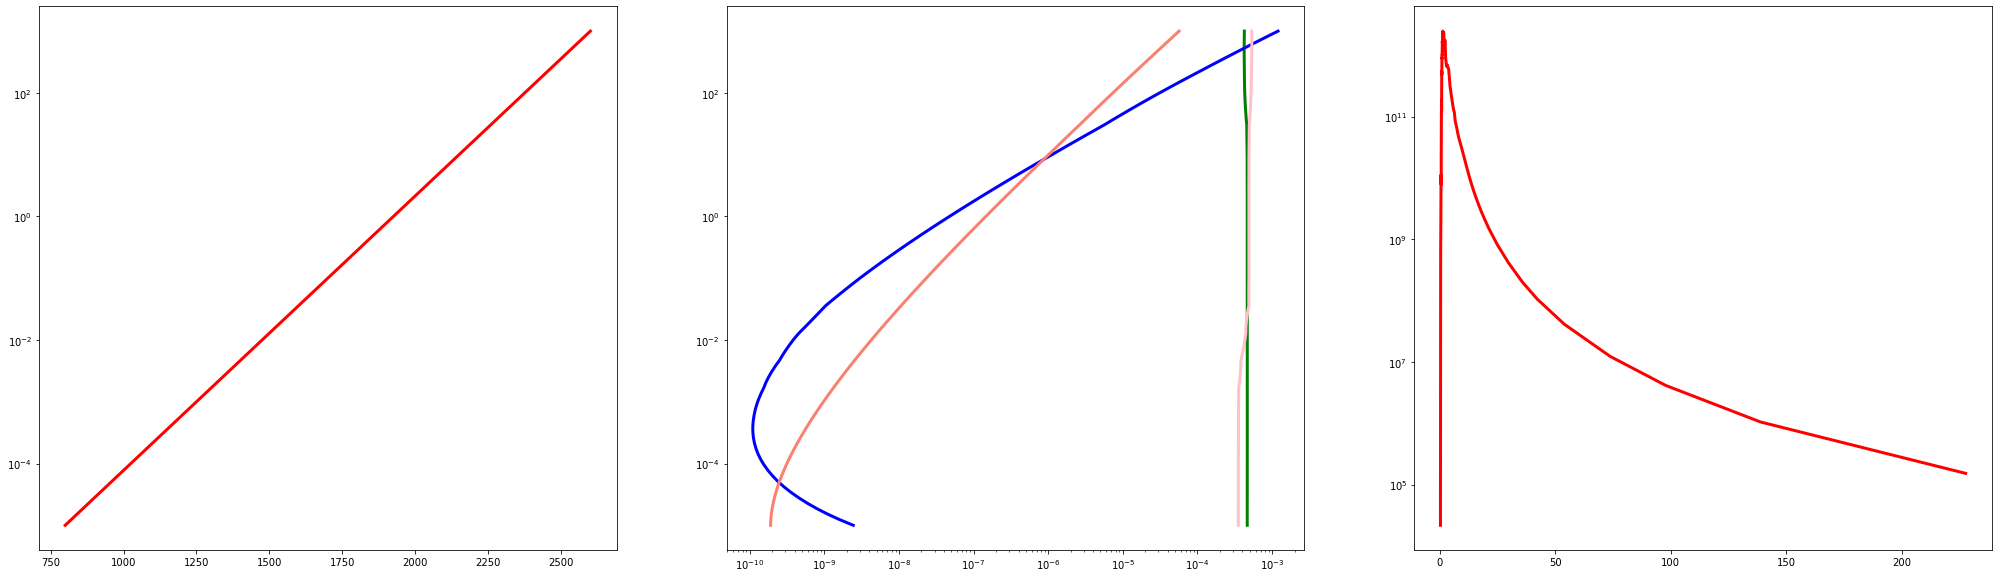

IndexError: index 36 is out of bounds for axis 0 with size 36

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
writergif = animation.PillowWriter(fps=3) 


x='''
AA.BB.CC
'''
fig = plt.figure(figsize=(35,10))
ax = fig.subplot_mosaic(x,gridspec_kw={
        # set the height ratios between the rows
        "height_ratios": [1],
        # set the width ratios between the columns
        "width_ratios": [1,1,0.1,1,1,0.1,1,1]})

temp = all_profiles_eq[0*91:(0+1)*91]

line, = ax['A'].semilogy(temp, p_eq,linewidth=3,color='r')
line1, = ax['B'].loglog(co[0:91], p_eq,linewidth=3,color='g',label="CO")
line2, = ax['B'].loglog(ch4[0:91], p_eq,linewidth=3,color='b',label="CH$_4$")
line3, = ax['C'].semilogy(1e4/df_spec['wavenumber'], spec[0,:],linewidth=3,color="r")
line4, = ax['B'].loglog(h2o[0:91], p_eq,linewidth=3,color='pink',label="H$_2$O")
line5, = ax['B'].loglog(nh3[0:91], p_eq,linewidth=3,color='salmon',label="NH$_3$")
#text to display the current frame
#time_text = ax['A'].text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top')

#Init function ti initialize variables 
def init():
    #line.set_ydata(np.ma.array(x, mask=True))
    
    ax['A'].set_xlabel('Temperature [K]',fontsize=20)
    ax['A'].set_ylabel('Pressure [Bars]',fontsize=20)
    ax['A'].set_xlim(200,2900)
    ax['A'].set_ylim(205,1.8e-4)
    ax['B'].set_xlabel('Abundance [V/V]',fontsize=20)
    ax['B'].set_ylabel('Pressure [Bars]',fontsize=20)
    ax['B'].set_xlim(1e-6,1e-2)
    ax['B'].set_ylim(205,1.8e-4)
    ax['B'].legend(fontsize=20)
    ax['C'].set_xlabel('Wavelength [$\mu$m]',fontsize=20)
    ax['C'].set_ylabel('Flux',fontsize=20)
    ax['C'].set_xlim(0,6)
    ax['C'].set_ylim(1e7,1e14)
    ax['A'].minorticks_on()
    ax['A'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
    ax['A'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
    ax['B'].minorticks_on()
    ax['B'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
    ax['B'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
    ax['C'].minorticks_on()
    ax['C'].tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
    ax['C'].tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)
    
    line.set_ydata(p_eq)
    line1.set_ydata(p_eq)
    line2.set_ydata(p_eq)
    line3.set_xdata(wv)
    line4.set_ydata(p_eq)
    line5.set_ydata(p_eq)
    
    #time_text.set_text('')
    return line,line1,line2,line3,line4,line5#,time_text        #return the variables that will updated in each frame
    
def animate(i):                  # 'i' is the number of frames  
    line.set_xdata(all_profiles_eq[i*91:(i+1)*91])
    line1.set_xdata(co[i*91:(i+1)*91])
    line2.set_xdata(ch4[i*91:(i+1)*91])
    line3.set_ydata(spec[i,:][wh])# update the data
    line4.set_xdata(h2o[i*91:(i+1)*91])
    line5.set_xdata(nh3[i*91:(i+1)*91])
    #time_text.set_text(' frame number = %.1d' % i)  
    return line,line1,line2,line3,line4,line5 #, time_text

ani = animation.FuncAnimation(fig, animate, frames=35,init_func=init,interval=10000000, blit=False)
plt.show()

ani.save('Benchmarking/anim_exo.gif', writer=writergif)